# This is Section 2 of CW1

The data required to run this notebook (inlcluding the notebook itself) is shared on Moodle-->coursework. The data is saved in a pickle format with the file name "clean_data_v2.pickle". You need to save this file on your PC,and then load it using an approprite file path, see the loading data section below.

You only need to fill out the parts that you are asked to do so. You can find these parts by looking
for word "Exercise" using Ctrl+F.

There are four exercises for this section. You may need to install certain packages in order for the code to run. All the necessary packages are below. 

Note that this notebook contains a lot of other information which is just for informative purposes, but in order to do the exercises you will need to understand the whole document (or at least most of it). You can try to explore this file.

The approximated number of lines requierd for coding for each exercise is provided to you. You should not feel guilty if your lines of codes are longer.

Marks for each exercise are shown in brakcets; note that these marks are provisional and they might be changed.


In [1]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import numpy as np
import pickle
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, brier_score_loss, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn import linear_model


In [2]:
### Define a default random seed and an output file

default_seed = 1
output_file = "output_sample"


In [3]:
#Loading the data from a compressed file
#Note that you could use a different path
data, discrete_features, continuous_features = pickle.load( 
    open( "/Users/yhj/Downloads/clean_data_v2.pickle", "rb" ) )


In [4]:
#Showing discrete_features
discrete_features

['home_ownership',
 'grade',
 'emp_length',
 'purpose',
 'verification_status',
 'term']

In [5]:
#Let us see how data looks like
data.head()


id  loan_amnt  funded_amnt        term  int_rate  installment grade  \
0  40390412     5000.0       5000.0   36 months     12.39       167.01     C   
2  40401108    17000.0      17000.0   36 months     12.39       567.82     C   
3  40501689     9000.0       9000.0   36 months     14.31       308.96     C   
4  40352737    14000.0      14000.0   36 months     11.99       464.94     B   
5  40431323    10000.0      10000.0   60 months     19.24       260.73     E   

  emp_length home_ownership  annual_inc  ...  total_pymnt last_pymnt_d  \
0   < 1 year           RENT     48000.0  ...   5475.14000   2015-12-01   
2     1 year           RENT     53000.0  ...  20452.09912   2018-03-01   
3    6 years           RENT     39000.0  ...   9792.56000   2015-11-01   
4    6 years           RENT     44000.0  ...  16592.91130   2018-01-01   
5  10+ years       MORTGAGE    130000.0  ...  15122.07997   2018-10-01   

  recoveries loan_length  term_num  ret_PESS   ret_OPT  ret_INTa  ret_INTb  \
0        0.0   10.973531        36  0.031676  0.103917  0.031155  0.050634   
2        0.0   37.947391        36  0.067688  0.064215  0.050574  0.066334   
3        0.0    9.987885        36  0.029354  0.105803  0.029798  0.049345   
4        0.0   36.008953        36  0.061736  0.061721  0.047093  0.063007   
5        0.0   44.978336        60  0.102442  0.136655  0.113866  0.131897   

   ret_INTc  
0  0.086751  
2  0.094950  
3  0.085622  
4  0.091937  
5  0.164518  

[5 rows x 33 columns]

In [6]:
#How many laons are there?
len(data.id)

605374

In [7]:
#Total amount of payments
sum(data.total_pymnt)

8839290030.931265

In [8]:
#Different types of interest rate definitions are defined here.
#Five types of return are defiend as discussed in class: these are called return_1, return_2
#return_3a, return_3b, return_3c

data['return_1'] = ( (data.total_pymnt - data.funded_amnt) 
                                            / data.funded_amnt ) * (12 / data['term_num'])

# Assuming that if a loan gives a positive return, we can
# immediately find a similar loan to invest in; if the loan
# takes a loss, we use method 2 to compute the return

#ops
data['return_2'] = ( (data.total_pymnt - data.funded_amnt)
                                            / data.funded_amnt ) * (12 / data['loan_length'])
data.loc[data.return_2 < 0,'return_2'] = data.return_1[data.return_2 < 0]
#####################
#Third Method where coupons are reinvested
def ret_method_3(T, i):
    '''
    Given an investment time horizon (in months) and re-investment
    interest rate, calculate the return of each loan
    '''
    
    # Assuming that the total amount paid back was paid at equal
    # intervals during the duration of the loan, calculate the
    # size of each of these installment
    actual_installment = (data.total_pymnt - data.recoveries) / data['loan_length']

    # Assuming the amount is immediately re-invested at the prime
    # rate, find the total amount of money we'll have by the end
    # of the loan
    cash_by_end_of_loan = actual_installment * (1 - pow(1 + i, data.loan_length)) / ( 1 - (1 + i) )
    
    cash_by_end_of_loan = cash_by_end_of_loan + data.recoveries
    
    # Assuming that cash is then re-invested at the prime rate,
    # with monthly re-investment, until T months from the start
    # of the loan
    remaining_months = T - data['loan_length']
    final_return = cash_by_end_of_loan * pow(1 + i, remaining_months)

    # Find the percentage return
    return( (12/T) * ( ( final_return - data['funded_amnt'] ) / data['funded_amnt'] ) )

data['return_3a'] = ret_method_3(5*12, 0.001)
data['return_3b'] = ret_method_3(5*12, 0.0025)
data['return_3c'] = ret_method_3(5*12, 0.005)


In [9]:
#putting all return names in one list
return_cols=["return_1","return_2","return_3a","return_3b","return_3c"]

In [10]:
data[return_cols].head()

return_1  return_2  return_3a  return_3b  return_3c
0  0.031676  0.103917   0.031155   0.050634   0.086751
2  0.067688  0.064215   0.050574   0.066334   0.094950
3  0.029354  0.105803   0.029798   0.049345   0.085622
4  0.061736  0.061721   0.047093   0.063007   0.091937
5  0.102442  0.136655   0.113866   0.131897   0.164518

In [11]:
#Calculate mean, standard deviation of returns; for instance:
print(data["return_2"].mean(), data["return_2"].std())


0.04580137736406625 0.10762826315058875


In [12]:
#Calculate correlation between continuous features
data[continuous_features].corr()

loan_amnt  funded_amnt  installment  annual_inc       dti  \
loan_amnt         1.000000     1.000000     0.952850    0.310914  0.020821   
funded_amnt       1.000000     1.000000     0.952850    0.310914  0.020821   
installment       0.952850     0.952850     1.000000    0.300108  0.024823   
annual_inc        0.310914     0.310914     0.300108    1.000000 -0.144491   
dti               0.020821     0.020821     0.024823   -0.144491  1.000000   
revol_bal         0.318580     0.318580     0.305464    0.281997  0.102385   
delinq_2yrs      -0.008796    -0.008796     0.000127    0.035928 -0.012619   
open_acc          0.182188     0.182188     0.169690    0.130390  0.213876   
pub_rec          -0.070506    -0.070506    -0.058493   -0.004934 -0.037522   
fico_range_high   0.113521     0.113521     0.067724    0.074356 -0.050331   
fico_range_low    0.113521     0.113521     0.067725    0.074356 -0.050328   
int_rate          0.123118     0.123118     0.139536   -0.086107  0.166301   
revol_util        0.112286     0.112286     0.126779    0.037410  0.141012   

                 revol_bal  delinq_2yrs  open_acc   pub_rec  fico_range_high  \
loan_amnt         0.318580    -0.008796  0.182188 -0.070506         0.113521   
funded_amnt       0.318580    -0.008796  0.182188 -0.070506         0.113521   
installment       0.305464     0.000127  0.169690 -0.058493         0.067724   
annual_inc        0.281997     0.035928  0.130390 -0.004934         0.074356   
dti               0.102385    -0.012619  0.213876 -0.037522        -0.050331   
revol_bal         1.000000    -0.029442  0.222358 -0.096787         0.030348   
delinq_2yrs      -0.029442     1.000000  0.046739 -0.021757        -0.171641   
open_acc          0.222358     0.046739  1.000000 -0.022263         0.031051   
pub_rec          -0.096787    -0.021757 -0.022263  1.000000        -0.197870   
fico_range_high   0.030348    -0.171641  0.031051 -0.197870         1.000000   
fico_range_low    0.030350    -0.171643  0.031053 -0.197872         1.000000   
int_rate         -0.044143     0.042665 -0.005516  0.058018        -0.375064   
revol_util        0.242095    -0.008660 -0.143820 -0.069936        -0.448503   

                 fico_range_low  int_rate  revol_util  
loan_amnt              0.113521  0.123118    0.112286  
funded_amnt            0.113521  0.123118    0.112286  
installment            0.067725  0.139536    0.126779  
annual_inc             0.074356 -0.086107    0.037410  
dti                   -0.050328  0.166301    0.141012  
revol_bal              0.030350 -0.044143    0.242095  
delinq_2yrs           -0.171643  0.042665   -0.008660  
open_acc               0.031053 -0.005516   -0.143820  
pub_rec               -0.197872  0.058018   -0.069936  
fico_range_high        1.000000 -0.375064   -0.448503  
fico_range_low         1.000000 -0.375067   -0.448504  
int_rate              -0.375067  1.000000    0.196467  
revol_util            -0.448504  0.196467    1.000000

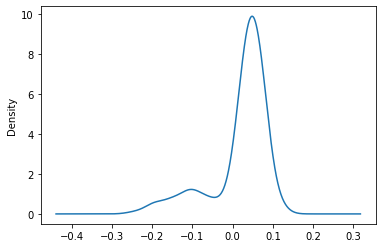

In [13]:
#Empirical densities
data["return_1"].iloc[0:500].plot.kde()
pass

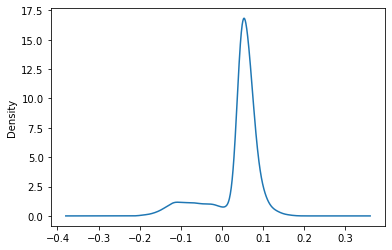

In [14]:
data["return_3b"].iloc[0:5000].plot.density()
pass

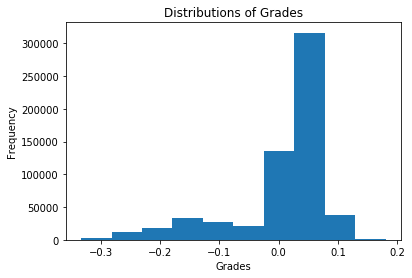

In [15]:
# create figure and axis
fig, ax = plt.subplots()
# plot histogram
ax.hist(data['return_1'])
# set title and labels
ax.set_title('Distributions of Grades')
ax.set_xlabel('Grades')
ax.set_ylabel('Frequency')
pass

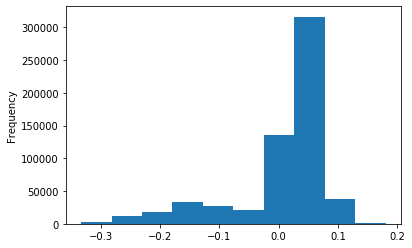

In [16]:
data['return_1'].plot.hist()


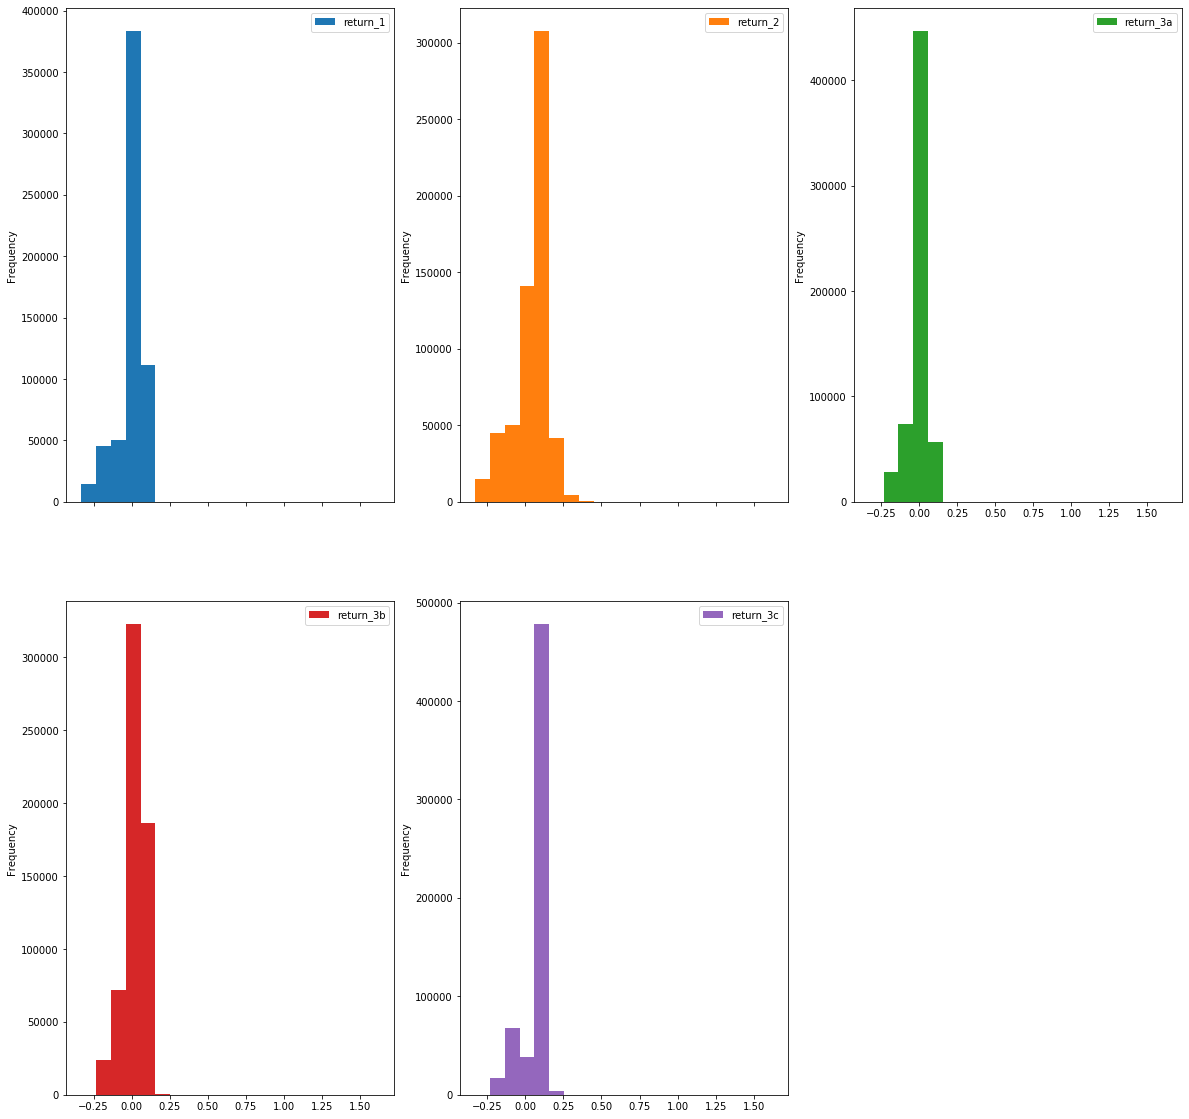

In [17]:
data[return_cols].plot.hist(subplots=True, layout=(2,3), figsize=(20, 20), bins=20)
pass

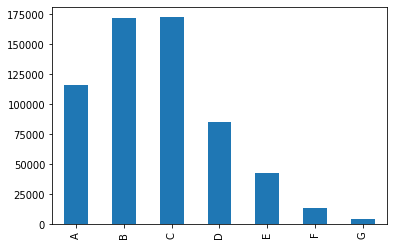

In [18]:
#bar charts: an example
data['grade'].value_counts().sort_index().plot.bar()
pass

In [19]:
#Seaborn is a Python data visualization library based on Matplotlib. It provides a high-level interface for
#creating attractive graphs. Seaborn has a lot to offer. You can create graphs in one line that would 
#take you multiple tens of lines in Matplotlib. Its standard designs are awesome and it 
#also has a nice interface for working with pandas dataframes.

import seaborn as sns 
%matplotlib inline

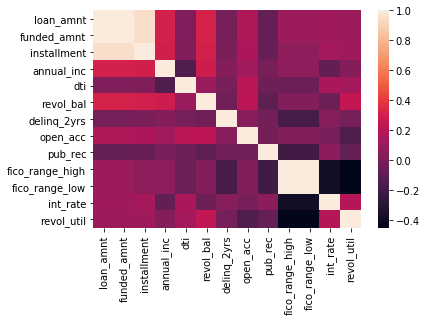

In [20]:
#A Heatmap is a graphical representation of data where the individual values contained in a matrix are 
#represented as colors. Heatmaps are perfect for exploring the correlation of features in a dataset.
#To get the correlation of the features inside a dataset we can call <dataset>.corr(), which is a 
#Pandas dataframe method. This will give us the correlation matrix.

sns.heatmap(data[continuous_features].corr(), annot=False)
pass

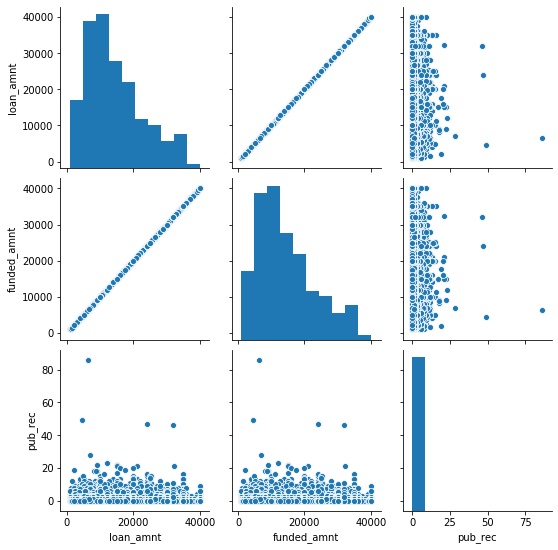

In [21]:
sns.pairplot(data[["loan_amnt","funded_amnt","pub_rec"]])


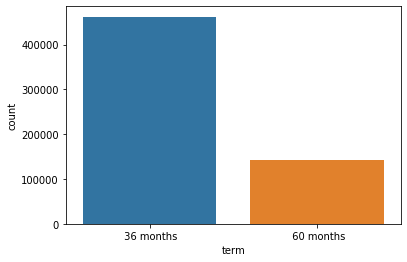

In [22]:
sns.countplot('term',data=data)

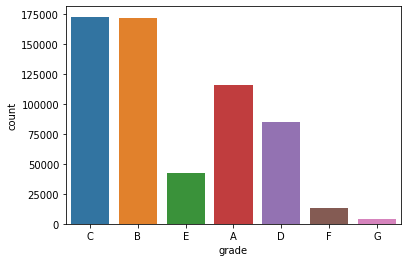

In [23]:
sns.countplot('grade',data=data)

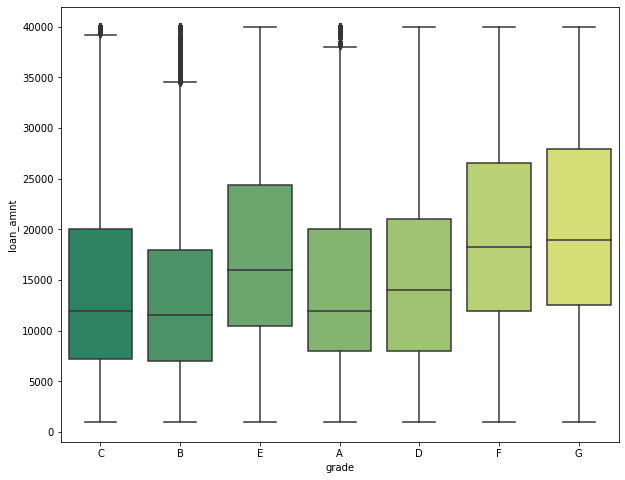

In [24]:
plt.figure(figsize=(10,8))
sns.boxplot(x='grade',y='loan_amnt',data=data,palette="summer")

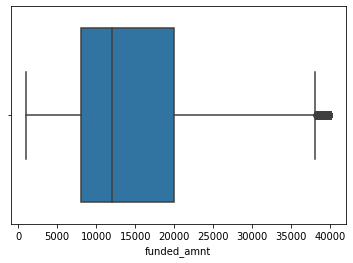

In [25]:
i=1
sns.boxplot(data[continuous_features[i]])


 

In [26]:
data.loan_status.value_counts()
data.loan_status
#(data.loan_status == "Charged Off" or data.loan_status == "Default")

0          Fully Paid
2          Fully Paid
3          Fully Paid
4          Fully Paid
5          Fully Paid
              ...    
1048430    Fully Paid
1048442    Fully Paid
1048471    Fully Paid
1048488    Fully Paid
1048541    Fully Paid
Name: loan_status, Length: 605374, dtype: object

In [27]:
#Exercise 1 --- 9 or 10 lines of coding - [5/15]
#For this exercise, first, find the percentage of loans by grade in the dataset. 
#Second, for each grade category, find the average of int_rate and return_1 of the loans. 
#Third, find the precentage of loans defaulted in each grade category. Show your result in a table like
#below. Store the result in a Panda dataframe and call it combined.
#
#
#----------------------------------
#Write your code bellow
perc_by_grade = (data.grade.value_counts()*100/len(data)).sort_index()
ret_by_grade_OPT = data.groupby("grade").apply(lambda x : np.mean(x.return_1)*100 )
#ret_by_grade_PESS = data.groupby("grade").apply(lambda x : np.mean(x.return_2)*100 )
#ret_by_grade_INTa = data.groupby("grade").apply(lambda x : np.mean(x.return_3a)*100 )
#ret_by_grade_INTb = data.groupby("grade").apply(lambda x : np.mean(x.return_3b)*100 )
#ret_by_grade_INTc = data.groupby("grade").apply(lambda x : np.mean(x.return_3c)*100 )
int_rate_by_grade = data.groupby("grade").apply(lambda x : np.mean(x.int_rate))

combined = pd.DataFrame(perc_by_grade)
combined['int_rate'] = int_rate_by_grade
combined['return_1'] = ret_by_grade_OPT
#combined['return_2'] = ret_by_grade_PESS
#combined['return_3a'] = ret_by_grade_INTa
#combined['return_3b'] = ret_by_grade_INTb
#combined['return_3c'] = ret_by_grade_INTc



default_by_grade=''
default_by_grade = data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
#default_by_grade = data.groupby("grade").apply(lambda x : (x.loan_status.isin(["Charged Off","Default"])).sum()*100/len(x) )

combined['default'] = default_by_grade


#----------------------------------

combined

# perc_by_grade = (data.grade.value_counts()*100/len(data)).sort_index()
# ret_by_grade_OPT = data.groupby("grade").apply(lambda x : np.mean(x.return_1)*100 )
# #ret_by_grade_PESS = data.groupby("grade").apply(lambda x : np.mean(x.return_2)*100 )
# #ret_by_grade_INTa = data.groupby("grade").apply(lambda x : np.mean(x.return_3a)*100 )
# #ret_by_grade_INTb = data.groupby("grade").apply(lambda x : np.mean(x.return_3b)*100 )
# #ret_by_grade_INTc = data.groupby("grade").apply(lambda x : np.mean(x.return_3c)*100 )
# int_rate_by_grade = ''# data.groupby("grade").apply(lambda x : np.mean(x.int_rate))

# combined = pd.DataFrame(perc_by_grade)
# combined['grade'] = ''
# combined['int_rate'] = ''# int_rate_by_grade
# combined['return_1'] = ''# ret_by_grade_OPT
# #combined['return_2'] = ret_by_grade_PESS
# #combined['return_3a'] = ret_by_grade_INTa
# #combined['return_3b'] = ret_by_grade_INTb
# #combined['return_3c'] = ret_by_grade_INTc



# default_by_grade=''
# #default_by_grade = data.groupby("grade").apply(lambda x : (x.loan_status != "Fully Paid").sum()*100/len(x) )
# combined['default'] = default_by_grade



grade   int_rate  return_1    default
A  19.184339   6.877237  1.649014   6.123802
B  28.356520  10.150223  1.324803  14.233120
C  28.562674  13.576124  0.427756  23.923868
D  14.029674  17.389625 -0.456187  33.344323
E   6.990885  20.601166 -1.382236  42.090215
F   2.179810  24.977874 -2.378748  50.545620
G   0.696099  28.598315 -3.714312  54.247746

In [28]:
# We add new columns to the data called "outcome" which indicates whether or not a loan is defaulted
data["outcome"] = data.loan_status.isin(["Charged Off", "Default"])
data["outcome"].head()


0    False
2    False
3    False
4    False
5    False
Name: outcome, dtype: bool

In [29]:
# Create a feature for the length of a person's credit history at the
# time the loan is issued
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [30]:
# Create a matrix of features and outcomes, convert categorical features using dummies. 
X_continuous = data[continuous_features]
X_discrete = pd.get_dummies(data["grade"], dummy_na = True, prefix_sep = "::", drop_first = False)
y = data.outcome.values

#store return values in y_return
y_return1=data.return_1
y_return2=data.return_2
y_return3a=data.return_3a
y_return3b=data.return_3b
y_return3c=data.return_3c

In [31]:
# For simplicity, we only consider the first seven discrete features as the space of
# features and the y_return1 as the resposne variable. 
#Split dataset into training set and test set for y_return1 for 60% training, 20% cross validation, and 20% testing
X_train, X_test, y_return_train, y_return_test = train_test_split(X_discrete.iloc[:,0:7], y_return1, test_size=0.4,
                                                                  random_state=default_seed) 
X_test, X_val, y_return_test, y_return_val = train_test_split(X_test, y_return_test, test_size=0.5,
                                                                  random_state=default_seed) 


In [32]:
#Performing a linear regression fitting for the return_1 with no regularization

grade_only_linear = LinearRegression()
grade_only_linear.fit(X_train, y_return_train)
parameters_linear = grade_only_linear.coef_

y_pred_linear = grade_only_linear.predict(X_test)

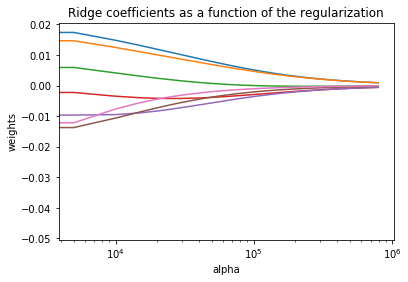

In [33]:
#Exercise 2 --- 9 or 10 lines of coding - [3/15]
#In this exercise, you have to display the effect of increasing the regularization parameter on the coefficients.
#More specifically, you need to obtain a figure where the horizontal axis is the regularization paramter and the
#vertical axis is the coefficients (or weights). This figure must display several curves together where each curve 
#represents one of the coefficients versus the regularization paramters, i.e. you need to obtain the following figure. 

#For the regularization parameters use the range range(0,800000,5000).
#Fit the linear model using the training dataset and include the bias term.
#Exclude the curve corresponding to the bias term in the final figure displayed.
#
#
#----------------------------------
#Write your code bellow


coefs = []
alphas=range(0,800000,5000)
for a in alphas:
    ridge = linear_model.Ridge(alpha=a, fit_intercept=True)
    ridge.fit(X_train, y_return_train)
    coefs.append(ridge.coef_)



ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

# #############################################################################
#End of the exercise


#Look at the figure below; what do you observe?

In [34]:
ridge.coef_

array([ 0.00089303,  0.00089401, -0.00015627, -0.00060481, -0.00059157,
       -0.00029476, -0.00013963])

In [35]:
ridge.intercept_

0.005518488067485872

In [36]:
#Searching for the optimal alpha using the cross validation dataset
#-----------------------
#Exercise 3 --- 11 or 12 lines of coding [5/15]
#Using the cross validation set, obtain the optimal alpha that minimizes the mean-square error
#of predicted returns on the cross validation set. Call this optiaml alpha, alpha_star and print it.
#You may use the following lists:
# error=[], error is a list that collects the mean square error on the training set.
# error_val=[], error_val is a list that collecets the mean-square-error on validation dataset
# You need to have a bias term in your fitting as well. 
# Note that you have to use an appropriate range for the alpha

# Note that you cannot use GridSearchCV for this exercise. 

#----------------------------------
#Write your codes here --- 4 or 5 lines of coding

error=[]
error_val=[]
alphas=range(0,1000,5)
for a in alphas:
    ridge_regular=linear_model.Ridge(alpha=a,fit_intercept=True)
    ridge_regular.fit(X_train,y_return_train)
    y_pred=ridge_regular.predict(X_train)
    y_pred_val=ridge_regular.predict(X_val)
   
    error.append(mean_squared_error(y_return_train,y_pred))
    error_val.append(mean_squared_error(y_pred_val,y_return_val))

min_index=error_val.index(min(error_val))
alpha_star=alphas[min_index]
print(alpha_star)
#--------------------------------------

565


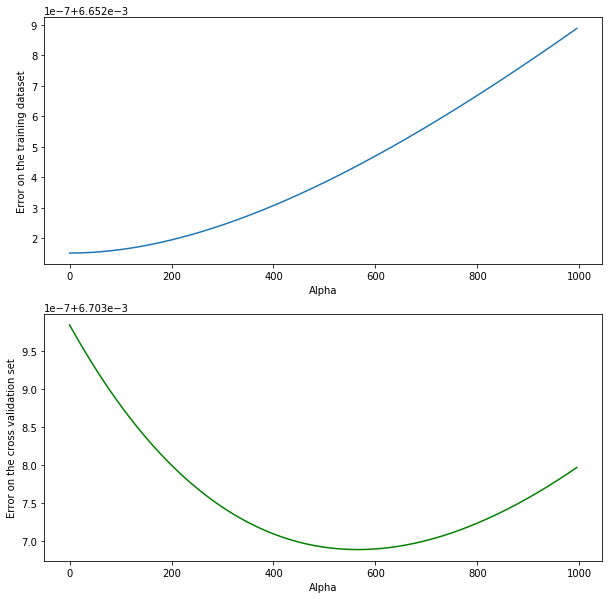

In [37]:
#The result of the last block could be shown graphically as follows:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.plot(alphas,error)
plt.xlabel('Alpha')
plt.ylabel('Error on the training dataset')

plt.subplot(2,1,2)
plt.plot(alphas,error_val,color='green')
plt.xlabel('Alpha')
plt.ylabel('Error on the cross validation set')
plt.show()
#Look at the following figures; what do you observe?

In [42]:
#Exercise 4 --- 4 or 5 lines of coding [2/15]

#Calcualte the mean-square error on the test dataset using the optimal alpha that you already obtained
#and the defaulted one used by the Ridge regression of the lienar model. Print the two mean-square error. 

#
#
#----------------------------------
#Write your codes here --- 4 or 5 lines of coding


ridge_regular_optimal=linear_model.Ridge(alpha=alpha_star,fit_intercept=True)
ridge_regular=linear_model.Ridge(alpha=1,fit_intercept=True)

ridge_regular_optimal.fit(X_train,y_return_train)
y_pred=ridge_regular.fit(X_train,y_return_train).predict(X_test)
y_pred_optimal=ridge_regular_optimal.predict(X_test)

print(mean_squared_error(y_pred,y_return_test))
print(mean_squared_error(y_pred_optimal,y_return_test))

#----------------------------------

0.006653111637479146
0.0066534301197469815


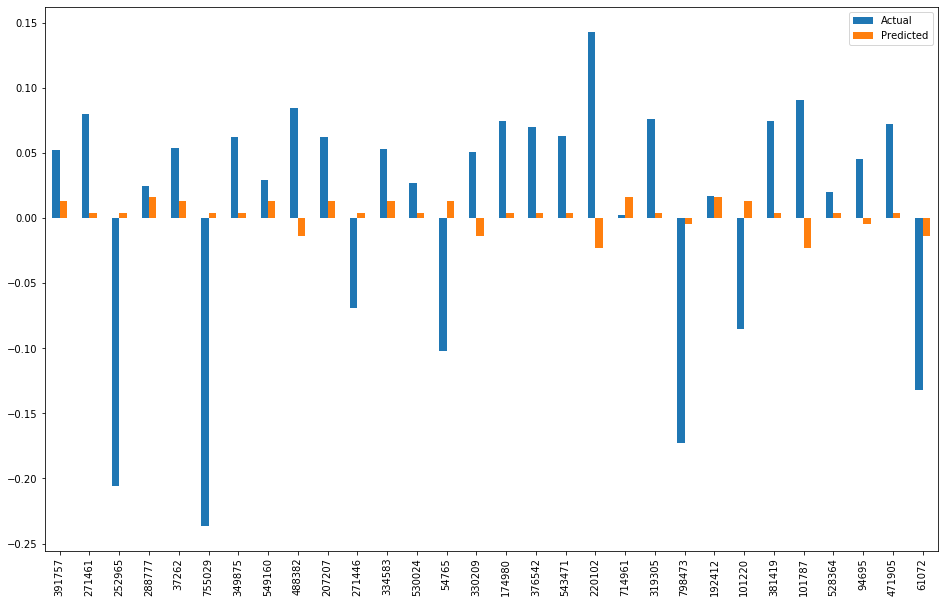

In [39]:
y_pred_train=ridge_regular_optimal.predict(X_train)
df = pd.DataFrame({'Actual': y_return_train, 'Predicted': y_pred_train})
df1 = df.head(30)

df1.plot(kind='bar',figsize=(16,10))
plt.show()